In [682]:
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error
from sklearn.tree import export_graphviz
import pandas as pd
import numpy as np
import requests 
import config # gitignored config.py file with API keys
import json 
import pydot
import folium 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
sns.set(rc={'figure.figsize':(20,8.27)})
%matplotlib inline

# Define the urban area: ZIP, Price, Rent, Lat, and Lng 
### Pulling all zip codes for the urban area

In [365]:
# Source https://worldpostalcode.com/united-states/new-york/new-york-city 
# retrieved on 05/28/2020
df_zipcodes = pd.read_csv('nyc_boroughs.csv', index_col = 0)
df_zipcodes.tail(2)

,zip,borough
238,11694,Queens
239,11697,Queens


In [366]:
df_zipcodes.shape

(240, 2)

This looks like a good size (n=240) sample of zip codes that can be used for the analysis

In [367]:
df_zipcodes.rename(columns={'borough':'Borough', 'zip':'Zipcode'}, inplace=True)
df_zipcodes.groupby('Borough').count()

,Zipcode
Borough,
Bronx,25
Brooklyn,43
Manhattan,96
Queens,63
Staten,13


### Adding Zillow price estimates 
Use the list of sample zip codes to get good price estimates, in my case, latest estimates of 2-bedroom condo units

In [368]:
# Source: https://www.zillow.com/research/data/
# retrieved on 05-18-2020
df_prices = pd.read_csv('condo_prices.csv', index_col=0)

In [369]:
# This data set contains zillow estimates for the entire nation
df_prices.shape

(10939, 299)

In [370]:
# Inspect the columns 
df_prices.head(2)

,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,215591.0,214255.0,...,1249908.0,1239499.0,1219219.0,1203053.0,1188642.0,1182534.0,1175894.0,1153407.0,1123011.0,1085220.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,194597.0,194456.0,...,403689.0,403756.0,403181.0,402122.0,401073.0,400025.0,399451.0,399424.0,400541.0,402007.0


In [371]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_prices.drop(df_prices.columns.difference(['RegionName', '2019-11-30']), 1, inplace=True)

In [372]:
df_nyc_prices = df_zipcodes.merge(df_prices, left_on='Zipcode', right_on='RegionName')
df_nyc_prices.shape

(157, 4)

Merged data set has less rows than original zip codes list but thats fine as there might have been some P.O boxes or reserved codes. The new list now has meaningful first feature - price estimate.

Check if all observations map to New York city boroughs or if there any unexpected values. Looks fine so far!

In [373]:
df_nyc_prices.groupby('Borough').count()

,Zipcode,RegionName,2019-11-30
Borough,,,
Bronx,16,16,16
Brooklyn,38,38,38
Manhattan,41,41,41
Queens,51,51,51
Staten,11,11,11


Finally, drop control column 'RegionName', rename the column to 'Price' and check if there are any missing values.

In [374]:
df_nyc_prices.rename(columns={'2019-11-30':'Price'}, inplace=True)
df_nyc_prices.drop(['RegionName'], axis=1, inplace=True)
df_nyc_prices['Price'].isna().values.any()

False

### Addining Zillow rental estimates

In [376]:
df_rents=pd.read_csv('condo_rentals.csv', index_col = 0)

In [377]:
df_rents.shape

(13181, 119)

In [378]:
df_rents.head(2)

,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3031.0,3058.0,3031.0,3015.0,...,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1790.0,1787.0,1784.0,1774.0,...,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0


In [379]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_rents.drop(df_rents.columns.difference(['RegionName', '2019-11']), 1, inplace=True)

In [380]:
df_nyc_prices_rents = df_nyc_prices.merge(df_rents, left_on='Zipcode', right_on='RegionName')
df_nyc_prices_rents.shape

(136, 5)

More observations (rows) were lost because not all zip codes had a rental estimate. Still seems to be a reasonable sample size (n=136).

In [381]:
df_nyc_prices_rents.groupby('Borough').count()

,Zipcode,Price,RegionName,2019-11
Borough,,,,
Bronx,16,16,16,15
Brooklyn,34,34,34,29
Manhattan,26,26,26,25
Queens,49,49,49,49
Staten,11,11,11,11


Moreover, from the grouped table above, it seems that some zip codes do have a price estimate but do not have rent estimate. So, drop missing values and check the data set. Drop control column and rename column 'Rent'.

In [382]:
df_nyc_prices_rents.rename(columns={'2019-11':'Rent'}, inplace=True)
df_nyc_prices_rents.drop(['RegionName'], axis=1, inplace=True)
df_nyc_prices_rents['Rent'].isna().values.any()

True

In [383]:
df_nyc_prices_rents.shape

(136, 4)

In [384]:
df_nyc_prices_rents.dropna(inplace=True)
df_nyc_prices_rents.shape

(129, 4)

In [158]:
df_nyc_prices_rents.shape

(129, 4)

In [385]:
df_nyc_prices_rents['Rent'].isna().values.any()

False

Final size is smaller (n=129) but there are no missing values

## Exploratory visual analysis

Inspect the rents visually with box plots

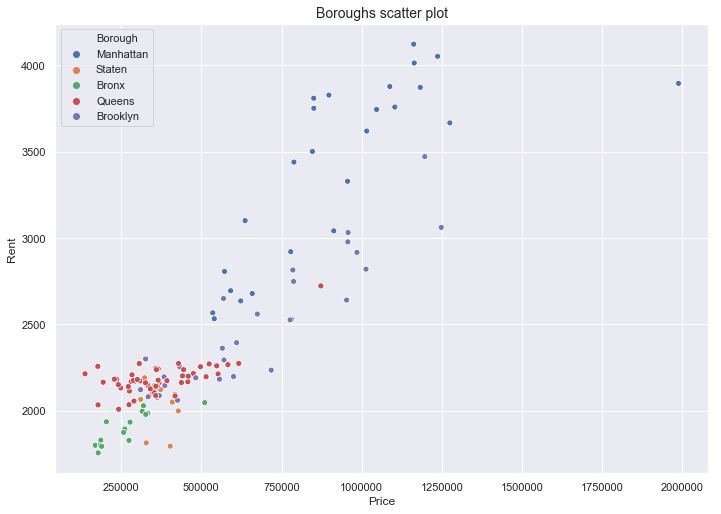

In [433]:
sns.scatterplot(x='Price', y='Rent', data=df_nyc_prices_rents, hue = 'Borough')
plt.gcf().set_size_inches(11.7, 8.27)
plt.title("Boroughs scatter plot", fontsize=14)
plt.show()

When plotting 'Rent' against 'Price" it seems that the data is not homegeneous at all. 

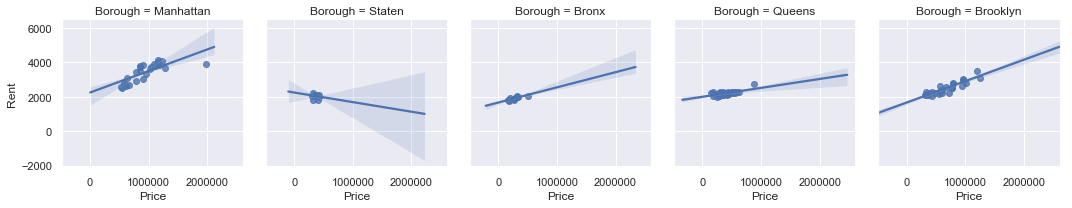

In [388]:
g1 = sns.lmplot(x='Price', y='Rent', data=df_nyc_prices_rents, ci=85,
                col='Borough', height=3, robust=False)
g1 = g1.set_axis_labels('Price', 'Rent')
plt.show()

Splitting by boroughs confirms this idea. When looking at the slope of regression lines, rent/price relationship appears to be different. There may be at list 3 distinct groups: 1) Manhattan, 2) Staten,  and 3) Bronx, Queens and Brooklyn.

### Algorithmic *k*-means clustering 

In [651]:
k_means = KMeans(init="k-means++", n_clusters=2, n_init=12)
k_means.fit(df_nyc_prices_rents[['Price', 'Rent']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [652]:
k_means_cluster_centers = k_means.cluster_centers_
pd.DataFrame(k_means_cluster_centers, columns=['Price', 'Rent'])

,Price,Rent
0,380208.428571,2169.612245
1,999254.566667,3309.333333


In [653]:
# Map clusters to demand types, i.e. low, medium , and high.
df_nyc_prices_rents["Cluster"] = k_means.labels_
df_nyc_prices_rents["Demand type"] = df_nyc_prices_rents["Cluster"].map({0 : "Low", 1 :"High", 2 : "Medium"})
df_nyc_prices_rents.head()

,Zipcode,Borough,Price,Rent,Cluster,Demand type,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,1,High,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,1,High,40.715775,-73.986212
2,10004,Manhattan,1236730.0,4053.0,1,High,40.688630,-74.018244
3,10005,Manhattan,1163758.0,4014.0,1,High,40.706027,-74.008835
4,10006,Manhattan,850713.0,3752.0,1,High,40.709614,-74.012954


In [654]:
# Check average price and rent by demand type cluster
round(df_nyc_prices_rents.groupby('Demand type')[["Price", "Rent"]].mean(), 2)

,Price,Rent
Demand type,,
High,999254.57,3309.33
Low,380208.43,2169.61


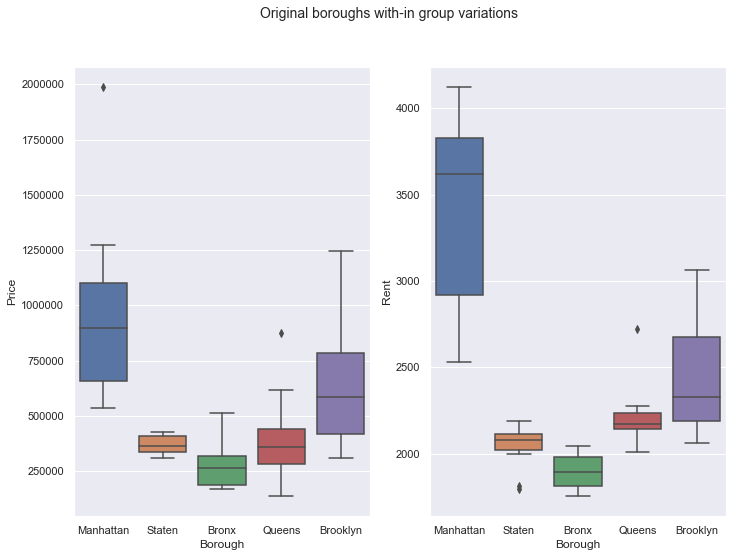

In [655]:
# Variance within original boroughs is large, especially in Manhattan and Brooklyn
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Original boroughs with-in group variations", fontsize=14) 
sns.boxplot(x="Borough", y="Price", data = df_nyc_prices_rents, ax=axes[0])
sns.boxplot(x="Borough", y="Rent", data = df_nyc_prices_rents, ax=axes[1])
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

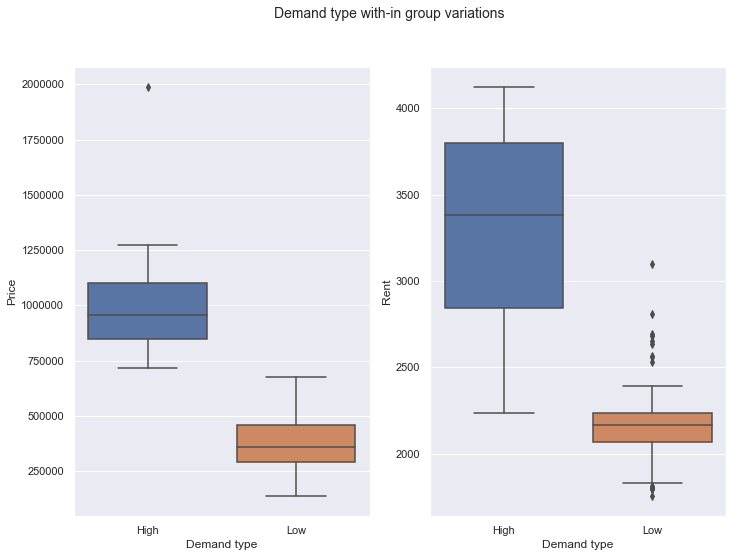

In [656]:
# Variance seems to be much smaller for demand typy clusters
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Demand type with-in group variations", fontsize=14) 
sns.boxplot(x="Demand type", y="Price", data = df_nyc_prices_rents, ax=axes[0])
sns.boxplot(x="Demand type", y="Rent", data = df_nyc_prices_rents, ax=axes[1])
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

## Adding geospatial data

In [44]:
# Source: https://gist.github.com/erichurst/7882666#file-us-zip-codes-from-2013-government-data
# Retrieved on 05/28/200
#df_zip_coordinates = pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')
# Due to importance of these coordinates, I make a local csv copy
#df_zip_coordinates.to_csv('zip_coordinates.csv')

In [434]:
df_zip_coordinates= pd.read_csv('zip_coordinates.csv', index_col = 0)
df_zip_coordinates.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [435]:
df_nyc_prices_rents = df_nyc_prices_rents.merge(df_zip_coordinates, left_on='Zipcode', right_on='ZIP')

In [436]:
df_nyc_prices_rents.head()

,Zipcode,Borough,Price,Rent,Cluster,Demand type,ZIP,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,2,Medium,10001,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,2,Medium,10002,40.715775,-73.986212
2,10004,Manhattan,1236730.0,4053.0,2,Medium,10004,40.688630,-74.018244
3,10005,Manhattan,1163758.0,4014.0,2,Medium,10005,40.706027,-74.008835
4,10006,Manhattan,850713.0,3752.0,0,Low,10006,40.709614,-74.012954


In [437]:
df_nyc_prices_rents.drop(['ZIP'], axis=1, inplace=True)
df_nyc_prices_rents.shape

(128, 8)

In [438]:
df_nyc_prices_rents['LAT'].isna().values.any()

False

In [439]:
df_nyc_prices_rents['LNG'].isna().values.any()

False

In [496]:
df_nyc_prices_rents.head(2)

,Zipcode,Borough,Price,Rent,Cluster,Demand type,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,2,Medium,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,2,Medium,40.715775,-73.986212


In [414]:
# Creat a local copy of teh entire data set for audit purposes:
#df_nyc_prices_rents.to_csv('nyc_pyces_rents.csv')

# Adding Local Venues

### Connecting to Foursquares server and data pull

In [72]:
#config.py file stores Client_ID and Client_Secret and is in gitignore
CLIENT_ID = config.CLIENT_ID 
CLIENT_SECRET = config.CLIENT_SECRET 
VERSION = '20191130'

In [458]:
latitude = df_nyc_prices_rents.loc[0, 'LAT'] 
longitude = df_nyc_prices_rents.loc[0, 'LNG'] # neighborhood longitude value
cluster = df_nyc_prices_rents.loc[0, 'Cluster'] # neighborhood name

#print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
#                                                               neighborhood_latitude, 
#                                                               neighborhood_longitude))

LIMIT = 500 
radius = 500

In [459]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)


In [460]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed62c1d660a9f001b4f64fd'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Chelsea',
  'headerFullLocation': 'Chelsea, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 61,
  'suggestedBounds': {'ne': {'lat': 40.7551330045, 'lng': -73.99124794397473},
   'sw': {'lat': 40.7461329955, 'lng': -74.00310605602532}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '59ca57dd3d47910ad148e668',
       'name': 'Bluestone Lane',
       'location': {'address': '435 W 31st St',
        'crossStreet': 'btwn 9th & Dyer Ave',
        'lat': 40.7520681,
        'lng': -73.9988477,
        'labeled

In [461]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [462]:
venues = results['response']['groups'][0]['items']
    
df_nearby_venues = json_normalize(venues) 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_nearby_venues = df_nearby_venues.loc[:, filtered_columns]
df_nearby_venues['venue.categories'] = df_nearby_venues.apply(get_category_type, axis=1)
df_nearby_venues.columns = [col.split(".")[-1] for col in df_nearby_venues.columns]

df_nearby_venues.head(2)

,name,categories,lat,lng
0,Bluestone Lane,Coffee Shop,40.752068,-73.998848
1,You Should Be Dancing…..! / Club 412,Dance Studio,40.750306,-73.994743


In [463]:
print('{} venues were returned by Foursquare.'.format(df_nearby_venues.shape[1]))

4 venues were returned by Foursquare.


In [464]:
def getNearbyVenues(zipcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
        print('Retrieving local values for the zip code:', zipcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [466]:
# Use to update df_nyc_venues table with data from Foursquares server

#df_nyc_venues = getNearbyVenues(zipcodes=df_nyc_prices_rents['Zipcode'],
#                             latitudes=df_nyc_prices_rents['LAT'],
#                             longitudes=df_nyc_prices_rents['LNG']
#                            )


In [467]:
print(df_nyc_venues.shape)
#Take back up of the data set for audit 
#df_nyc_venues.to_csv('nyc_venues_r500.csv')
df_nyc_venues.tail()

(5142, 7)


,Zip,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5137,11691,40.601278,-73.761651,A Train Shuttle Bus Stop,40.599722,-73.761665,Bus Stop
5138,11697,40.555688,-73.920663,Pelham Walk,40.558499,-73.922276,Trail
5139,11697,40.555688,-73.920663,"Ocean Ave, Breezy Pt",40.558337,-73.918602,Beach
5140,11697,40.555688,-73.920663,Dugout,40.559381,-73.919297,Pizza Place
5141,11697,40.555688,-73.920663,Breezy Point Ballfield Playground,40.559614,-73.919073,Park


In [469]:
print('There are {} uniques categories.'.format(len(df_nyc_venues['Venue Category'].unique())))

There are 376 uniques categories.


In [541]:
#nyc_venues.head()

# one hot encoding
df_nyc_onehot = pd.get_dummies(df_nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_nyc_onehot['Zip'] = df_nyc_venues['Zip'] 

# move neighborhood column to the first column
fixed_columns = [df_nyc_onehot.columns[-1]] + list(df_nyc_onehot.columns[:-1])
df_nyc_onehot = df_nyc_onehot[fixed_columns]

df_nyc_onehot.head()

,Zip,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [542]:
df_nyc_onehot.shape

(5142, 377)

In [601]:
df_nyc_grouped = df_nyc_onehot.groupby('Zip').mean().reset_index()
#df_nyc_grouped = df_nyc_onehot.groupby('Zip').count().reset_index()
df_nyc_grouped.head()

,Zip,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.00
2,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
3,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.01
4,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.03,0.0,0.01,0.00


In [602]:
df_nyc_grouped.shape

(128, 377)

### Creating analysis data set 

In [658]:
df_analysis_dataset = df_nyc_prices_rents.merge(df_nyc_grouped, left_on='Zipcode', right_on='Zip')
df_analysis_dataset.drop(['Zipcode', 'Borough', 'LAT', 'LNG', 'Cluster', 'Zip'], axis=1, inplace=True)
df_analysis_dataset.head(2)

,Price,Rent,Demand type,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1274766.0,3667.0,High,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,1103197.0,3759.0,High,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.0,0.02,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0


In [659]:
y_price = df_analysis_dataset['Price']
y_price_high = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'High']['Price']
#y_price_medium = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'Medium']['Price']
y_price_low = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'Low']['Price']

y_rent = df_analysis_dataset['Rent']
y_rent_high = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'High']['Rent']
#y_rent_medium = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'Medium']['Rent']
y_rent_low = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'Low']['Rent']

df_analysis_dataset.drop(['Price', 'Rent'], axis=1, inplace=True)

In [661]:
X_high = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'High'].copy()
#X_medium = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'Medium'].copy()
X_low = df_analysis_dataset.loc[df_analysis_dataset['Demand type'] == 'Low'].copy()

In [662]:
print("High demand y price:", y_price_high.shape, " and y rent ", y_rent_high.shape, " X ", X_high.shape)
#print("Medium demand y price:", y_price_medium.shape, " and y rent ", y_rent_medium.shape, " X ", X_medium.shape)
print("Low demand y price:", y_price_low.shape, " and y rent is ", y_rent_low.shape, " X is ", X_low.shape)

High demand y price: (30,)  and y rent  (30,)  X  (30, 377)
Low demand y price: (98,)  and y rent is  (98,)  X is  (98, 377)


In [663]:
X = df_analysis_dataset.drop(['Demand type'], axis=1)
X_high.drop(['Demand type'], axis=1, inplace=True)
#X_medium.drop(['Demand type'], axis=1, inplace=True)
X_low.drop(['Demand type'], axis=1, inplace=True)

# Saving feature names for later use
feature_list = list(X.columns)

In [664]:
X.shape

(128, 376)

In [665]:
# Split all the data into training and testing sets - benchmark model
X_train, X_test, y_price_train, y_price_test = train_test_split(X, y_price, 
                                                                test_size = 0.20, random_state = 0)

X_train, X_test, y_rent_train, y_rent_test = train_test_split(X, y_rent, 
                                                              test_size = 0.20, random_state = 0)

# Same for high demand areas:
X_high_train, X_high_test, y_price_high_train, y_price_high_test = train_test_split(X_high, y_price_high, 
                                                                test_size = 0.20, random_state = 0)

X_high_train, X_high_test, y_rent_high_train, y_rent_high_test = train_test_split(X_high, y_rent_high, 
                                                                test_size = 0.20, random_state = 0)

# Low demand areas:
X_low_train, X_low_test, y_price_low_train, y_price_low_test = train_test_split(X_low, y_price_low, 
                                                                test_size = 0.20, random_state = 0)

X_low_train, X_low_test, y_rent_low_train, y_rent_low_test = train_test_split(X_low, y_rent_low, 
                                                                test_size = 0.20, random_state = 0)


# Random forest of regression trees

In [695]:
# Need a function that takes split train/test values, runs regr, 
# makes pred, computes three measure - MAPE, R2, explained variance + dollar off
# and plots features
# Another code block to update the tree chart

In [729]:
def run_random_forests(title, X_features, y_target, size, depth, n_runs, seed):
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = size, random_state = seed)
    rf_regression = RandomForestRegressor(max_depth=depth, n_estimators=n_runs, random_state=seed)
    rf_regression.fit(X_train, y_train)
    y_hat = rf_regression.predict(X_test)
    print("Performance measures for ", title, "model")
    print("R2 score: ", round(r2_score(y_test, y_hat), 2))
    print("Explained variance: ", round(explained_variance_score(y_test, y_hat), 2))
    print("Mean absolute error:" , round((np.mean(np.abs((y_test - y_hat) / y_test))), 2))
    print("On average predictions are off by" , round(mean_absolute_error(y_test, y_hat), 0), "$") 
    plot_feature_importance(title, rf_regression)
    update_tree_png(title, rf_regression)
    
def plot_features_importance(title, rf_regression):
    # Get numerical feature importances
    importances = list(rf_regression.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    x_val = [x[0] for x in feature_importances[0:10]]
    y_val = [x[1] for x in feature_importances[0:10]]
    plt.barh(x_val, y_val, edgecolor='black')
    plt.title('Top 10 features for explaining {}:'.format(title))
    plt.show()
    
def update_tree_png(title, rf_regression):
    pass
    # Pull out one tree from the forest
    tree = rf_regression.estimators_[5]
    # Export the image to a dot file
    export_graphviz(tree, out_file = title + '_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
    # Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file(title + '_tree.dot')
    # Write graph to a png file
    graph.write_png(title + '_tree.png')
    
    
    

### Benchmark price model

In [666]:
price_regr = RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=0)
price_regr.fit(X_train, y_price_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [683]:
# Use the forest's predict method on the test data
predictions = price_regr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_price_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_price_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('MAPE accuracy of benchmark price tree:', round(accuracy, 2), '%.')

MAPE accuracy of benchmark price tree: 79.2 %.


In [684]:
preds = price_regr.predict(X_test)
print("R2 score: ", round(r2_score(y_price_test,preds, preds), 2))
print("Explained variance: ", round(explained_variance_score(y_price_test, preds), 2))
#print(mean_absolute_error(y_price_test, preds) / mean_squared_error(y_price_test, preds))
print("Mean absolute error:" , round((np.mean(np.abs((y_price_test - preds) / y_price_test))), 2))
print("On average predictions are off by" , round(mean_absolute_error(y_price_test, preds), 0), "$") 

R2 score:  0.72
Explained variance:  0.74
MAE: 0.21
On average predictions are off by 105060.0 $


Performance measures for  benchmark_price model
R2 score:  0.73
Explained variance:  0.74
Mean absolute error: 0.21
On average predictions are off by 105060.0 $


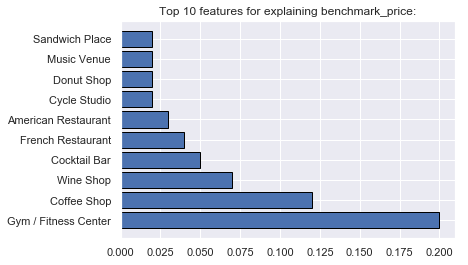

In [734]:
run_random_forests("benchmark_price", X, y_price, 0.2, 5, 1000, 0)

Performance measures for  benchmark_rent model
R2 score:  0.62
Explained variance:  0.62
Mean absolute error: 0.1
On average predictions are off by 260.0 $


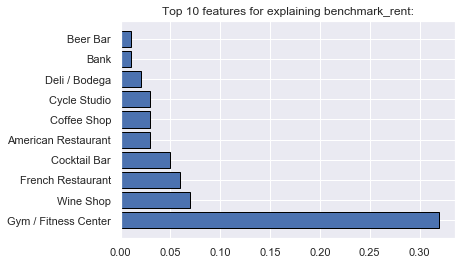

In [733]:
run_random_forests("benchmark_rent", X, y_rent, 0.2, 5, 1000, 0)

Performance measures for  high_price model
R2 score:  0.04
Explained variance:  0.2
Mean absolute error: 0.12
On average predictions are off by 129132.0 $


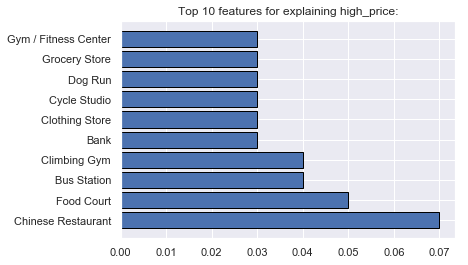

In [745]:
run_random_forests("high_price", X_high, y_price_high, 0.3, 5, 500, 0)

Performance measures for  high_rent model
R2 score:  0.16
Explained variance:  0.42
Mean absolute error: 0.14
On average predictions are off by 401.0 $


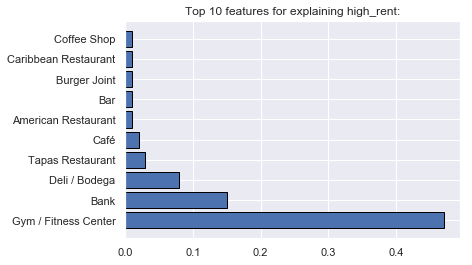

In [748]:
run_random_forests("high_rent", X_high, y_rent_high, 0.2, 5, 1000, 0)

Performance measures for  low_price model
R2 score:  -0.12
Explained variance:  -0.06
Mean absolute error: 0.25
On average predictions are off by 88039.0 $


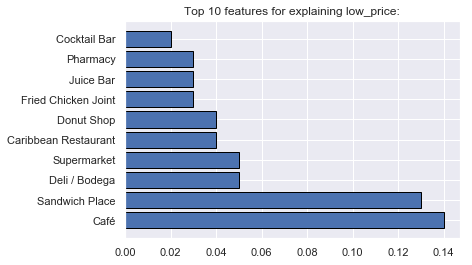

In [747]:
run_random_forests("low_price", X_low, y_price_low, 0.2, 5, 1000, 0)

Performance measures for  low_rent model
R2 score:  -0.06
Explained variance:  0.06
Mean absolute error: 0.08
On average predictions are off by 172.0 $


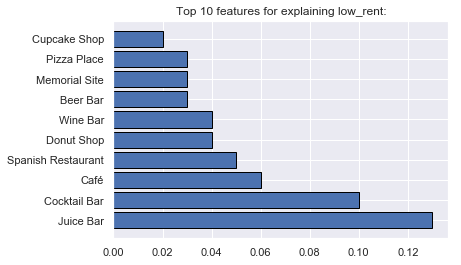

In [749]:
run_random_forests("low_rent", X_low, y_rent_low, 0.2, 5, 1000, 0)

In [685]:
# Pull out one tree from the forest
tree = price_regr.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'nyc_price_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('nyc_price_tree.dot')
# Write graph to a png file
graph.write_png('nyc_price_tree.png')

In [686]:
# Get numerical feature importances
importances = list(price_regr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

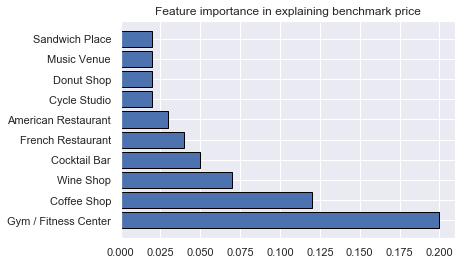

In [687]:
x_val = [x[0] for x in feature_importances[0:10]]
y_val = [x[1] for x in feature_importances[0:10]]
plt.barh(x_val,y_val, edgecolor='black')
plt.title('Feature importance in explaining benchmark price')
plt.show()

### General rent model

In [688]:
rent_regr = RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=0)
rent_regr.fit(X_train, y_rent_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [689]:
# Use the forest's predict method on the test data
predictions = rent_regr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_rent_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_rent_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('MAPE accuracy of benchmark rent model:', round(accuracy, 2), '%.')

MAPE accuracy of benchmark rent model: 90.16 %.


In [690]:
# Checks:
preds = rent_regr.predict(X_test)
print("R2 score: ", round(r2_score(y_rent_test, preds), 2))
print("Explained variance: ", round(explained_variance_score(y_rent_test, preds), 2))
print("MAE:" , round((np.mean(np.abs((y_rent_test - preds) / y_rent_test))), 2))
print("On average predictions are off by" , round(mean_absolute_error(y_rent_test, preds), 0), "$") 

R2 score:  0.62
Explained variance:  0.62
MAE: 0.1
On average predictions are off by 260.0 $


In [691]:
print("On average predictions are off by" , round(mean_absolute_error(y_rent_test, predictions), 0), "$") 

On average predictions are off by 260.0 $


In [692]:
# Import tools needed for visualization
#from sklearn.tree import export_graphviz
#import pydot
# Pull out one tree from the forest
tree = rent_regr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'nyc_rent_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('nyc_rent_tree.dot')
# Write graph to a png file
graph.write_png('nyc_rent_tree.png')

In [693]:
# Get numerical feature importances
importances = list(rent_regr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

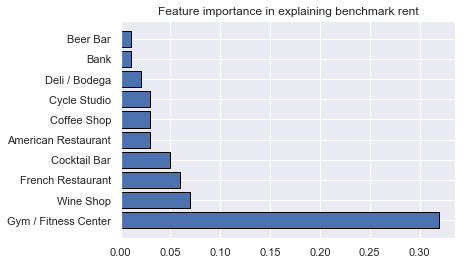

In [694]:
x_val = [x[0] for x in feature_importances[0:10]]
y_val = [x[1] for x in feature_importances[0:10]]
plt.barh(x_val,y_val, edgecolor='black')
plt.title('Feature importance in explaining benchmark rent')
plt.show()

### High demand price model

In [639]:
high_price_regr = RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=0)
high_price_regr.fit(X_high_train, y_price_high_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [640]:
# Use the forest's predict method on the test data
predictions = high_price_regr.predict(X_high_test)
# Calculate the absolute errors
errors = abs(predictions - y_price_high_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_price_high_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy of high demand price model:', round(accuracy, 2), '%.')

Accuracy of high demand price model: 83.88 %.


In [641]:
print("On average predictions are off by" , round(mean_absolute_error(y_price_high_test, predictions), 2), "$") 

On average predictions are off by 55649.7 $


In [642]:
# Import tools needed for visualization
#from sklearn.tree import export_graphviz
#import pydot
# Pull out one tree from the forest
tree = high_price_regr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'high_price_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('high_price_tree.dot')
# Write graph to a png file
graph.write_png('high_price_tree.png')

In [643]:
# Get numerical feature importances
importances = list(high_price_regr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

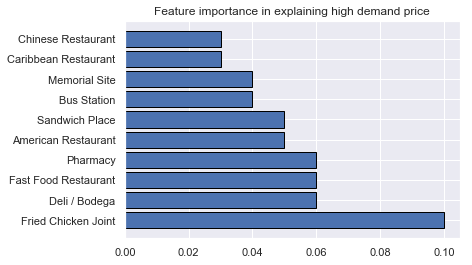

In [644]:
x_val = [x[0] for x in feature_importances[0:10]]
y_val = [x[1] for x in feature_importances[0:10]]
plt.barh(x_val,y_val, edgecolor='black')
plt.title('Feature importance in explaining high demand price')
plt.show()

### High demand rent model 

In [645]:
high_rent_regr = RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=0)
high_rent_regr.fit(X_high_train, y_rent_high_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [646]:
# Use the forest's predict method on the test data
predictions = high_rent_regr.predict(X_high_test)
# Calculate the absolute errors
errors = abs(predictions - y_rent_high_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_rent_high_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy of high demand rent model:', round(accuracy, 2), '%.')

Accuracy of high demand rent model: 95.5 %.


In [647]:
print("On average predictions are off by" , round(mean_absolute_error(y_rent_high_test, predictions), 0), "$") 

On average predictions are off by 99.0 $


In [648]:
# Import tools needed for visualization
#from sklearn.tree import export_graphviz
#import pydot
# Pull out one tree from the forest
tree = high_rent_regr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'high_rent_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('high_rent_tree.dot')
# Write graph to a png file
graph.write_png('high_rent_tree.png')

In [649]:
# Get numerical feature importances
importances = list(high_rent_regr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

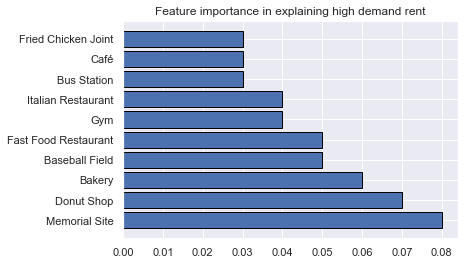

In [650]:
x_val = [x[0] for x in feature_importances[0:10]]
y_val = [x[1] for x in feature_importances[0:10]]
plt.barh(x_val,y_val, edgecolor='black')
plt.title('Feature importance in explaining high demand rent')
plt.show()

### Medium demand price model

### Medium demand rent model 

### Low demand price model

### Low demand rent model

### Summary of feature importance 

In [283]:
fi = pd.DataFrame({'Predicting_price': list(X_train.columns),
                   'Importance_price': price_regr.feature_importances_,
                  'High demand price': list(X_high_train.columns),
                  'High demand importance': high_price_regr.feature_importances_}).\
                    sort_values('Importance_price', ascending = False)

In [284]:
fi

,Predicting_price,Importance_price,High demand price,High demand importance
164,Gym / Fitness Center,0.204958,Gym / Fitness Center,3.996670e-02
83,Coffee Shop,0.115670,Coffee Shop,9.489874e-02
372,Wine Shop,0.069255,Wine Shop,5.656404e-02
82,Cocktail Bar,0.052266,Cocktail Bar,2.727667e-03
145,French Restaurant,0.040456,French Restaurant,7.262610e-03
6,American Restaurant,0.031501,American Restaurant,1.367021e-03
115,Donut Shop,0.023246,Donut Shop,3.263084e-04
240,Music Venue,0.022783,Music Venue,2.709766e-04
101,Cycle Studio,0.021632,Cycle Studio,3.675521e-02
298,Sandwich Place,0.017012,Sandwich Place,1.526635e-02
